In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [2]:
import string
import nltk
from nltk.corpus import stopwords
import re
import random

In [3]:
from sklearn import model_selection, preprocessing, feature_extraction, linear_model, metrics, svm, neighbors

In [4]:
from functools import partial

In [38]:
import pickle

In [5]:
data = pd.read_csv('dataset/IMDB_Dataset.csv')

In [6]:
data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [7]:
data.sentiment.replace("positive", 1, inplace = True)
data.sentiment.replace("negative", 0, inplace = True)
data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1


In [8]:
X = data['review']
y = data['sentiment']

In [9]:
# radimo izbor hiperparametara pomocu validacionog skupa
X_train_val, X_test, y_train_val, y_test = model_selection.train_test_split(X, y, test_size=0.33, stratify=y, random_state=1234)

In [10]:
X_train, X_val, y_train, y_val = model_selection.train_test_split(X_train_val, y_train_val, test_size=0.2, stratify=y_train_val, random_state=1234)

In [11]:
X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

((26800,), (6700,), (16500,), (26800,), (6700,), (16500,))

In [12]:
y_train.value_counts()

1    13400
0    13400
Name: sentiment, dtype: int64

In [13]:
y_val.value_counts()

0    3350
1    3350
Name: sentiment, dtype: int64

In [14]:
y_test.value_counts()

0    8250
1    8250
Name: sentiment, dtype: int64

## Bag of Words i TF-IDF vektorizacija

In [15]:
# pomocne funkcije iz 01:
def simple_tokenization(review):
    tokens = nltk.tokenize.word_tokenize(review)
    tokens_without_punctuation = [token for token in tokens if token not in string.punctuation]
    return tokens_without_punctuation

In [16]:
def short_form_transform(text):
    text=re.sub("isn't", 'is not', text)
    text=re.sub("aren't", 'are not', text)
    text=re.sub("he's", 'he is', text)
    text=re.sub("wasn't", 'was not',text)
    text=re.sub("there's", 'there is',text)
    text=re.sub("couldn't",'could not',text)
    text=re.sub("can't", 'can not', text)
    text=re.sub("won't", 'will not',text)
    text=re.sub("they're", 'they are',text)
    text=re.sub("she's", 'she is',text)
    text=re.sub("wouldn't", 'would not',text)
    text=re.sub("haven't", 'have not',text)
    text=re.sub("that's", 'that is',text)
    text=re.sub("you've", 'you have',text)
    text=re.sub("he's", 'he is',text)
    text=re.sub("what's", 'what is',text)
    text=re.sub("weren't", 'were not',text)
    text=re.sub("we're", 'we are',text)
    text=re.sub("hasn't", 'has not',text)
    text=re.sub('i’d','i would',text)
    text=re.sub("you'd",'you would',text)
    text=re.sub("shouldn't",'should not',text)
    text=re.sub("let's",'let us',text)
    text=re.sub("i've", 'i have', text)
    text=re.sub("you've", 'you have', text)
    text=re.sub("we've", 'we have', text)
    text=re.sub("they've",'they have',text)
    text=re.sub("you'll",'you will',text)
    text=re.sub("i'm",'i am',text)
    text=re.sub("we've",'we have',text)
    text=re.sub("it's",'it is',text)
    text=re.sub("don't",'do not',text)
    text=re.sub("doesn't", 'does not',text)
    text=re.sub("didn't", 'did not', text)
    text=re.sub("hadn't", 'had not', text)
    text=re.sub("mightn't", 'might not', text)
    text=re.sub("mustn't", 'must not', text)
    text=re.sub("it's",'it is',text)
    return text

In [17]:
# eliminacija html tagova
def strip_html(review):
    return re.sub('<[^<]+?>', '', review)

# eliminacija url-ova
def strip_url(review):
    return re.sub(r'http\S+', '', review)

# c.g.i -> cgi, u.s.a -> usa
def full_stop_abbrev_elim(review):
    pattern = re.compile(r'\b(?:[a-z]\.){2,}', re.I)
    review = pattern.sub(lambda m: m.group().replace('.',''), review)
    return review

def remove_stop_words(tokens):
    stopwords_list = stopwords.words('english')
    tokens_without_stop = [token.strip() for token in tokens if token.strip() not in stopwords_list]
    return tokens_without_stop

In [18]:
def review_preprocessor(text):
    text = text.lower()
    text = short_form_transform(text)
    text = strip_html(text)
    text = strip_url(text)
    text = full_stop_abbrev_elim(text)
    return text

In [19]:
# najmanje agresivan:
# stemmer = nltk.stem.PorterStemmer(mode='NLTK_EXTENSIONS') # default mode (NLTK_EXTENSIONS) se pokazao kao najbolji
# nesto agresivniji:
# stemmer = nltk.stem.snowball.SnowballStemmer(language='english')
# najagresivniji:
# stemmer = nltk.stem.lancaster.LancasterStemmer()

def review_tokenizer(stemming, text):
    tokens = simple_tokenization(text)
    tokens = remove_stop_words(tokens)
            
    stems = []
        
    for token in tokens:
        
        token_pattern = re.compile(r'\b[^\W\d_]+\b')
        if not token_pattern.match(token) or len(token) <= 2:
            continue
        
        stem = stemming.stem(token)
        stems.append(stem)
    return stems

In [20]:
def init_vectorizer(vect_type: str, preprocessor, tokenizer, min_df, max_df, norm='l2', smooth_idf=True, use_idf=True):
    if type(vect_type) is not str:
        raise TypeError("vect_type must be string!")
    if vect_type.lower() not in ['count', 'tf-idf']:
        raise ValueError("Supported vectorization types: 'count', 'td-idf'!")
    
    if vect_type.lower() == 'count':
        return feature_extraction.text.CountVectorizer(preprocessor=preprocessor, tokenizer=tokenizer, min_df=min_df,
                                                         max_df=max_df, token_pattern=None)
    
    if vect_type.lower() == 'tf-idf':
        return feature_extraction.text.TfidfVectorizer(preprocessor=preprocessor, tokenizer=tokenizer, min_df=min_df,
                                                        max_df=max_df, token_pattern=None,
                                                        norm=norm, smooth_idf=smooth_idf, use_idf=use_idf)

In [21]:
review_tokenizer_snowball = partial(review_tokenizer, nltk.stem.snowball.SnowballStemmer(language='english') )
vectorizer1 = init_vectorizer(vect_type='tf-idf', preprocessor=review_preprocessor, tokenizer=review_tokenizer_snowball,
                                min_df=0.05, max_df=0.7)
# min_df - hocemo da izbacimo jako retke reci
# max_df - hocemo da izbacimo preceste reci (corpus-specific stopwords)

In [22]:
vectorizer1.fit(X_train)

TfidfVectorizer(max_df=0.7, min_df=0.05,
                preprocessor=<function review_preprocessor at 0x0000026D8768B910>,
                token_pattern=None,
                tokenizer=functools.partial(<function review_tokenizer at 0x0000026D87688CA0>, <nltk.stem.snowball.SnowballStemmer object at 0x0000026D80948820>))

In [23]:
# sve reci u vokabularu
vectorizer1.get_feature_names_out()

array(['absolut', 'act', 'action', 'actor', 'actual', 'almost', 'along',
       'also', 'although', 'alway', 'amaz', 'american', 'anoth', 'anyon',
       'anyth', 'appear', 'around', 'ask', 'attempt', 'audienc', 'aw',
       'away', 'back', 'bad', 'base', 'beauti', 'becom', 'begin',
       'believ', 'best', 'better', 'big', 'bit', 'black', 'book', 'bore',
       'boy', 'bring', 'budget', 'call', 'came', 'camera', 'care', 'case',
       'cast', 'certain', 'chang', 'charact', 'classic', 'clear', 'close',
       'come', 'comedi', 'comment', 'complet', 'consid', 'could', 'coupl',
       'cours', 'creat', 'dark', 'day', 'dead', 'death', 'decid',
       'definit', 'dialogu', 'die', 'differ', 'direct', 'director',
       'disappoint', 'done', 'dvd', 'earli', 'effect', 'either', 'els',
       'emot', 'end', 'enjoy', 'enough', 'entertain', 'entir', 'episod',
       'especi', 'even', 'ever', 'everi', 'everyon', 'everyth', 'exampl',
       'excel', 'except', 'expect', 'experi', 'extrem', 'eye', '

In [24]:
X_train_vectorized = vectorizer1.transform(X_train)
X_val_vectorized = vectorizer1.transform(X_val)

In [25]:
X_train_vectorized.shape, X_val_vectorized.shape

((26800, 351), (6700, 351))

## Logisticka regresija

In [27]:
Cs = np.array([10**i for i in range(-5,5)])
penalties = np.array(['l1', 'l2', 'elasticnet'])
l1_ratios = np.array([0.1 * i for i in range(1, 10)])

best_score = float('-inf')
best_C = None
best_penalty = None
best_l1_ratio = None

for C in Cs:
    for penalty in penalties:
        
        if penalty == 'l2': 
            model = linear_model.LogisticRegression(C=C, max_iter=500, penalty=penalty, solver='lbfgs')
            model.fit(X_train_vectorized, y_train)
        
            score = metrics.accuracy_score(y_val, model.predict(X_val_vectorized))
            # print(f'C: {C} penalty: {penalty} - score: {score}')
            if score > best_score:
                best_score = score
                best_C = C
                best_penalty = penalty
        
        if penalty == 'l1': 
                                                                                        # 'lbfgs' ne podrzava
            model = linear_model.LogisticRegression(C=C, max_iter=500, penalty=penalty, solver='liblinear')
            model.fit(X_train_vectorized, y_train)
        
            score = metrics.accuracy_score(y_val, model.predict(X_val_vectorized))
            # print(f'C: {C} penalty: {penalty} - score: {score}')
            if score > best_score:
                best_score = score
                best_C = C
                best_penalty = penalty   
        
        
        if penalty == 'elasticnet':
            
            for l1_ratio in l1_ratios:
                                                                                            # 'lbfgs' ne podrzava
                model = linear_model.LogisticRegression(C=C, max_iter=500, penalty=penalty, solver='saga', l1_ratio=l1_ratio)
                model.fit(X_train_vectorized, y_train)
        
                score = metrics.accuracy_score(y_val, model.predict(X_val_vectorized))
                # print(f'C: {C} penalty: {penalty} l1_ratio: {l1_ratio} - score: {score}')
                if score > best_score:
                    best_score = score
                    best_C = C
                    best_penalty = penalty 
                    best_l1_ratio = l1_ratio
                    
# print("----------------------------------------------------------------------------------------------")
if best_penalty == 'elasticnet':
    print(f'Najbolja vrednost regularizacionog hiperparametra: {best_C}\nNajbolja norma regularizacije: {best_penalty}')
    print(f'Najbolji l1_ratio: {best_l1_ratio}\nNajbolji skor: {best_score}')
else:
    print(f'Najbolja vrednost regularizacionog hiperparametra: {best_C}\nNajbolja norma regularizacije: {best_penalty}')
    print(f'Najbolji skor: {best_score}')

Najbolja vrednost regularizacionog hiperparametra: 1.0
Najbolja norma regularizacije: elasticnet
Najbolji l1_ratio: 0.4
Najbolji skor: 0.8365671641791045


In [26]:
vectorizer2 = init_vectorizer(vect_type='tf-idf', preprocessor=review_preprocessor, tokenizer=review_tokenizer_snowball,
                                min_df=0.05, max_df=0.7)

In [27]:
vectorizer2.fit(X_train_val)

TfidfVectorizer(max_df=0.7, min_df=0.05,
                preprocessor=<function review_preprocessor at 0x0000026D8768B910>,
                token_pattern=None,
                tokenizer=functools.partial(<function review_tokenizer at 0x0000026D87688CA0>, <nltk.stem.snowball.SnowballStemmer object at 0x0000026D80948820>))

In [28]:
X_train_val_vec = vectorizer2.transform(X_train_val)
X_test_vec = vectorizer2.transform(X_test)

In [29]:
X_train_val_vec.shape, X_test_vec.shape

((33500, 353), (16500, 353))

In [32]:
final_lr_model = None
if best_penalty == 'l2':
    final_lr_model = linear_model.LogisticRegression(C=best_C, max_iter=500, penalty=best_penalty, solver='lbfgs')
if best_penalty == 'l1':
    final_lr_model = linear_model.LogisticRegression(C=best_C, max_iter=500, penalty=best_penalty, solver='liblinear')
if best_penalty == 'elasticnet':
    final_lr_model = linear_model.LogisticRegression(C=best_C, max_iter=500, penalty=best_penalty,
                                                     solver='saga', l1_ratio=best_l1_ratio)

In [31]:
final_lr_model.fit(X_train_val_vec, y_train_val)

LogisticRegression(l1_ratio=0.4, max_iter=500, penalty='elasticnet',
                   solver='saga')

In [32]:
lr_train_score = final_lr_model.score(X_train_val_vec, y_train_val)
print(lr_train_score)

0.8402089552238806


In [33]:
lr_test_score = final_lr_model.score(X_test_vec, y_test)
print(lr_test_score)

0.8350909090909091


In [34]:
y_test_predicted = final_lr_model.predict(X_test_vec)

In [35]:
print(metrics.classification_report(y_test, y_test_predicted))

              precision    recall  f1-score   support

           0       0.84      0.82      0.83      8250
           1       0.83      0.85      0.84      8250

    accuracy                           0.84     16500
   macro avg       0.84      0.84      0.84     16500
weighted avg       0.84      0.84      0.84     16500



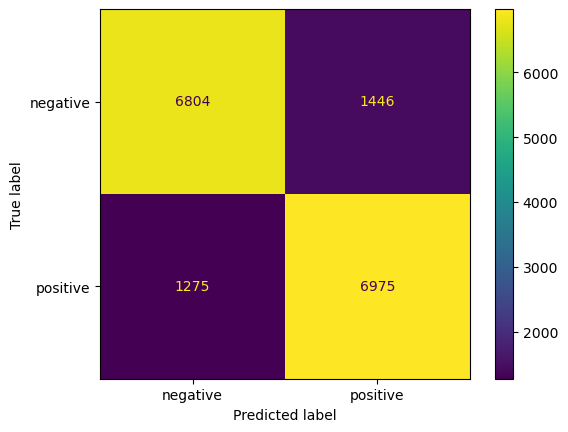

In [36]:
confusion_matrix = metrics.confusion_matrix(y_test, y_test_predicted)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels=['negative', 'positive'])
cm_display.plot()
plt.show()

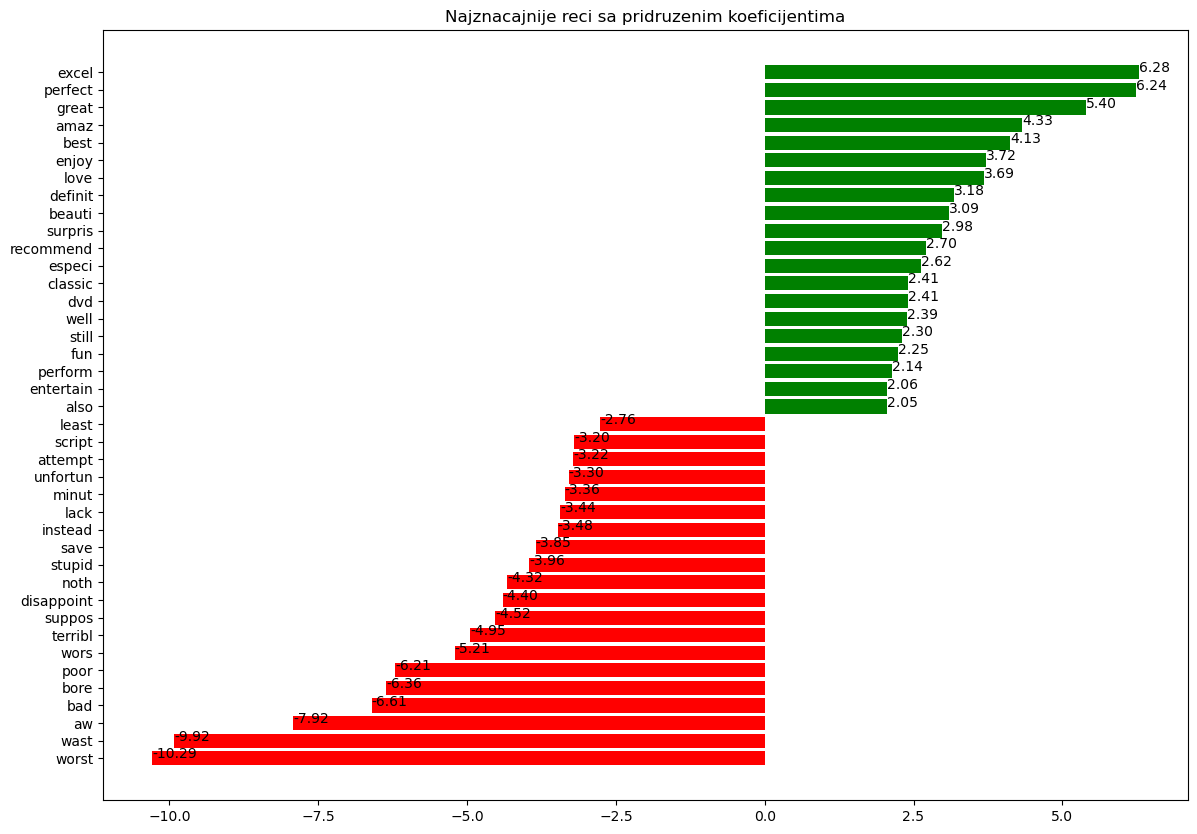

In [37]:
coefs = final_lr_model.coef_.reshape(-1)

pos_coeff_indices = np.argsort(coefs)[-20:]
neg_coeff_indices = np.argsort(coefs)[:20]
    
indices = np.hstack((neg_coeff_indices, pos_coeff_indices))
    
plt.figure(figsize=(14,10))
plt.title('Najznacajnije reci sa pridruzenim koeficijentima')
colors = ['red' if c < 0 else 'green' for c in coefs[indices]]
plt.barh(y=np.arange(40), width=coefs[indices], color=colors)

plt.yticks(ticks=np.arange(40), labels=np.array(vectorizer2.get_feature_names_out())[indices])

for index, value in enumerate(coefs[indices]):
    plt.text(value, index, "{:.2f}".format(value))
plt.show()

In [41]:
# cuvanje vektorizatora
vectorizer_filename = 'vectorizers/tf_idf.vect'
with open(vectorizer_filename, 'wb') as pickle_file:
    pickle.dump(vectorizer2, pickle_file)

In [42]:
# cuvanje modela
model_filename = 'models/log_reg.model'
with open(model_filename, 'wb') as pickle_file:
    pickle.dump(final_lr_model, pickle_file)

## Kernelizovani SVM

In [44]:
X_train_vectorized.shape, X_val_vectorized.shape

((26800, 351), (6700, 351))

In [61]:
Cs = np.array([10**i for i in range(-3, 3)])
# scale - 1 / (n_features * X.var())
# auto - 1/ n_features
gammas = ['scale', 'auto']
kernels = ['linear', 'rbf', 'sigmoid']

best_score = float('-inf')
best_params = {'C': None, 'gamma': None, 'kernel': None}

for C in Cs:
    for gamma in gammas:
        for kernel in kernels:
            model = svm.SVC(C=C, gamma=gamma, kernel=kernel)
            
            model.fit(X_train_vectorized, y_train)
            score = metrics.accuracy_score(y_val, model.predict(X_val_vectorized))                        
            # print(f'C: {C} gamma: {gamma} kernel: {kernel} - score: {score}')
            if score > best_score:
                best_score = score
                best_params['C'] = C
                best_params['gamma'] = gamma
                best_params['kernel'] = kernel


# print('------------------------------------------------------------------------')
print(f"Najbolja vrednost regularizacionog hiperparametra: {best_params['C']}")
print(f"Najbolji tip kernela: {best_params['kernel']}")

if best_params['kernel'] != 'linear':
    print(f"Najbolji koeficijent kernela: {best_params['gamma']}")

print(f'Najbolji skor: {best_score}')

Najbolja vrednost regularizacionog hiperparametra: 1.0
Najbolji tip kernela: rbf
Najbolji koeficijent kernela: scale
Najbolji skor: 0.8417910447761194


In [45]:
X_train_val_vec.shape, X_test_vec.shape

((33500, 353), (16500, 353))

In [103]:
final_svm_model = None
if best_params['kernel'] == 'linear':
    # probability= True - da izracuna verovatnoce (potrebno za predict_proba)
    final_svm_model = svm.SVC(C=best_params['C'], kernel=best_params['kernel'], probability=True)
else:
    final_svm_model = svm.SVC(C=best_params['C'], gamma=best_params['gamma'], kernel=best_params['kernel'], probability=True)

In [104]:
final_svm_model.fit(X_train_val_vec, y_train_val)

SVC(probability=True)

In [105]:
svm_train_score = final_svm_model.score(X_train_val_vec, y_train_val)
print(svm_train_score)

0.9412238805970149


In [106]:
# doslo je do preprilagodjavanja
svm_test_score = final_svm_model.score(X_test_vec, y_test)
print(svm_test_score)

0.8418787878787879


In [107]:
y_test_predicted = final_svm_model.predict(X_test_vec)

In [108]:
print(metrics.classification_report(y_test, y_test_predicted))

              precision    recall  f1-score   support

           0       0.85      0.83      0.84      8250
           1       0.83      0.86      0.84      8250

    accuracy                           0.84     16500
   macro avg       0.84      0.84      0.84     16500
weighted avg       0.84      0.84      0.84     16500



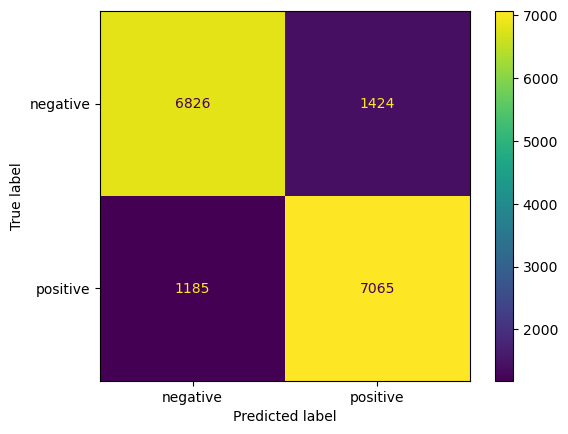

In [109]:
confusion_matrix = metrics.confusion_matrix(y_test, y_test_predicted)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels=['negative', 'positive'])
cm_display.plot()
plt.show()

In [110]:
# ne mogu se izracunati za nelinarni kernel
# final_svm.model.coef_

In [111]:
# cuvanje modela:
model_filename = 'models/svm.model'
with open(model_filename, 'wb') as pickle_file:
    pickle.dump(final_svm_model, pickle_file)

## K najblizih suseda

In [56]:
X_train_vectorized.shape, X_val_vectorized.shape

((26800, 351), (6700, 351))

In [40]:
Ks = np.array([10*i for i in range(1, 10)])
dist_metrics = ['manhattan', 'euclidean']

best_score = float('-inf')
best_params = {'K': None, 'metric': None}

accuracies = {'manhattan': [], 'euclidean': []}                     
              
for K in Ks:
    for metric in dist_metrics:
        model = neighbors.KNeighborsClassifier(n_neighbors=K, metric=metric)
              
        model.fit(X_train_vectorized, y_train)
        score = metrics.accuracy_score(y_val, model.predict(X_val_vectorized))
        accuracies[metric].append(score)
        # print(f'K: {K} metric: {metric} - score: {score}')
        if score > best_score:
            best_score = score
            best_params['K'] = K
            best_params['metric'] = metric

# print('------------------------------------------------------------------------')            
print(f"Najbolji broj suseda : {best_params['K']}")
print(f"Najbolja metrika: {best_params['metric']}")
print(f'Najbolji skor: {best_score}')

Najbolji broj suseda : 50
Najbolja metrika: euclidean
Najbolji skor: 0.7756716417910448


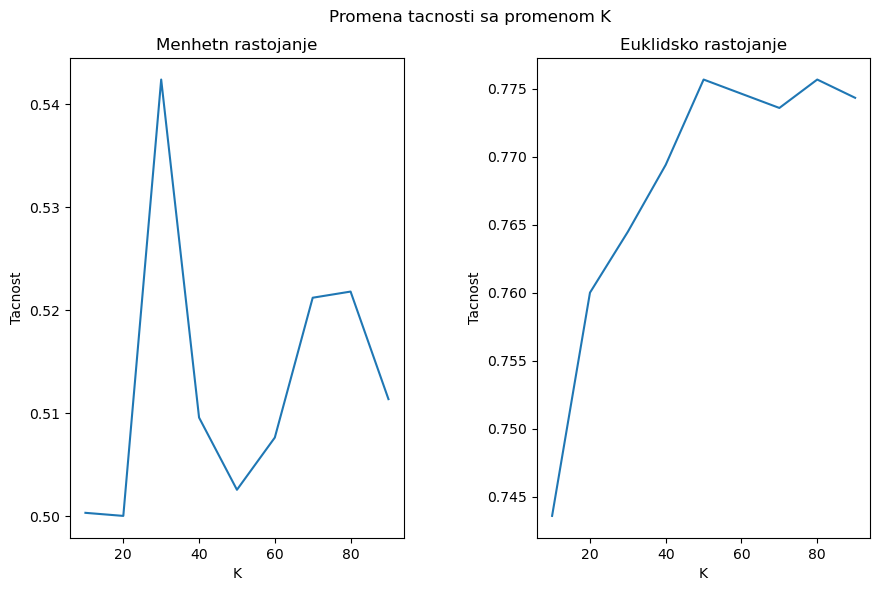

In [41]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))
ax1.plot(Ks, accuracies['manhattan'])
ax1.set_title('Menhetn rastojanje')
ax1.set_xlabel('K')
ax1.set_ylabel('Tacnost')

ax2.plot(Ks, accuracies['euclidean'])
ax2.set_title('Euklidsko rastojanje')
ax2.set_xlabel('K')
ax2.set_ylabel('Tacnost')

fig.suptitle('Promena tacnosti sa promenom K')

plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.4,
                    hspace=0.4)

plt.show()

In [57]:
final_knn_model = neighbors.KNeighborsClassifier(n_neighbors=best_params['K'], metric=best_params['metric'])

In [58]:
final_knn_model.fit(X_train_val_vec, y_train_val)

KNeighborsClassifier(metric='euclidean', n_neighbors=50)

In [59]:
knn_train_score = final_knn_model.score(X_train_val_vec, y_train_val)
print(knn_train_score)

0.7893432835820896


In [60]:
knn_test_score = final_knn_model.score(X_test_vec, y_test)
print(knn_test_score)

0.7821818181818182


In [61]:
y_test_predicted = final_knn_model.predict(X_test_vec)

In [62]:
print(metrics.classification_report(y_test, y_test_predicted))

              precision    recall  f1-score   support

           0       0.80      0.75      0.77      8250
           1       0.77      0.81      0.79      8250

    accuracy                           0.78     16500
   macro avg       0.78      0.78      0.78     16500
weighted avg       0.78      0.78      0.78     16500



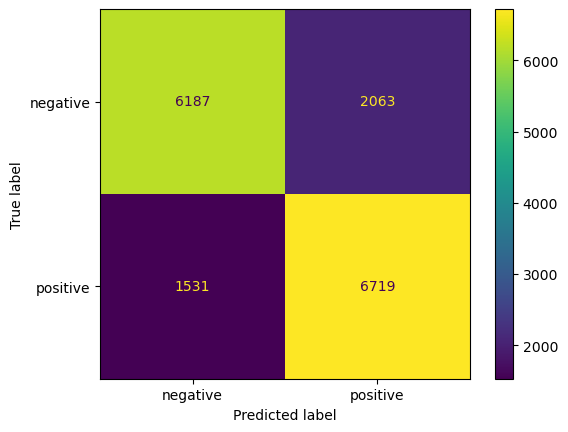

In [65]:
confusion_matrix = metrics.confusion_matrix(y_test, y_test_predicted)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels=['negative', 'positive'])
cm_display.plot()
plt.show()

In [69]:
# cuvanje modela:
model_filename = 'models/knn.model'
with open(model_filename, 'wb') as pickle_file:
    pickle.dump(final_knn_model, pickle_file)

## Uporedna analiza modela

In [112]:
# ucitavanje vektorizatora i modela
vectorizer_filename = 'vectorizers/tf_idf.vect'
with open(vectorizer_filename, 'rb') as pickle_file:
    tf_idf_vectorizer = pickle.load(pickle_file)
        
lr_filename = 'models/log_reg.model'
with open(lr_filename, 'rb') as pickle_file:
    lr_model = pickle.load(pickle_file)
    
svm_filename = 'models/svm.model'
with open(svm_filename, 'rb') as pickle_file:
    svm_model = pickle.load(pickle_file)
    
knn_filename = 'models/knn.model'
with open(knn_filename, 'rb') as pickle_file:
    knn_model = pickle.load(pickle_file)

In [117]:
X_test_vec = tf_idf_vectorizer.transform(X_test)
models = [lr_model, svm_model, knn_model]
roc_auc_scores = [metrics.roc_auc_score(y_test, model.predict(X_test_vec)) for model in models]

[0.8350909090909091, 0.8418787878787878, 0.7821818181818181]

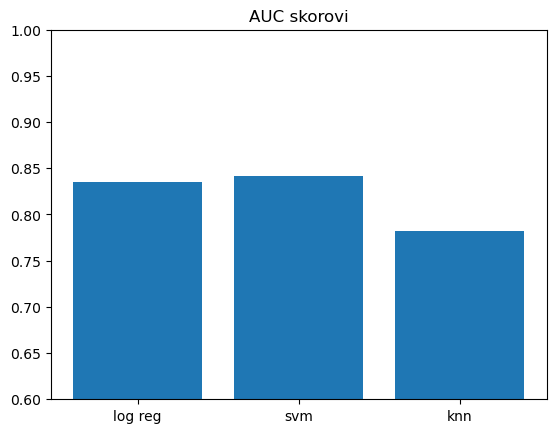

In [80]:
plt.title('AUC skorovi')
plt.bar(['log reg', 'svm', 'knn'], roc_auc_scores)
plt.ylim([0.6, 1])
plt.show()

In [85]:
y_prob_lr = lr_model.predict_proba(X_test_vec) [:, 1] # verovatnoca predvidjanja pozitivne klase 
fpr_lr, tpr_lr, thresholds_lr = metrics.roc_curve(y_test, y_prob_lr)

In [118]:
# svm - verovatnoca kao udaljenost od razdvajajuce hiperravni
y_prob_svm = svm_model.predict_proba(X_test_vec) [:, 1] # verovatnoca predvidjanja pozitivne klase 
fpr_svm, tpr_svm, thresholds_svm = metrics.roc_curve(y_test, y_prob_svm)

In [99]:
# knn - verovatnoca kao udeo suseda koji pripadaju klasi
y_prob_knn = knn_model.predict_proba(X_test_vec) [:, 1] # verovatnoca predvidjanja pozitivne klase 
fpr_knn, tpr_knn, thresholds_knn = metrics.roc_curve(y_test, y_prob_knn)

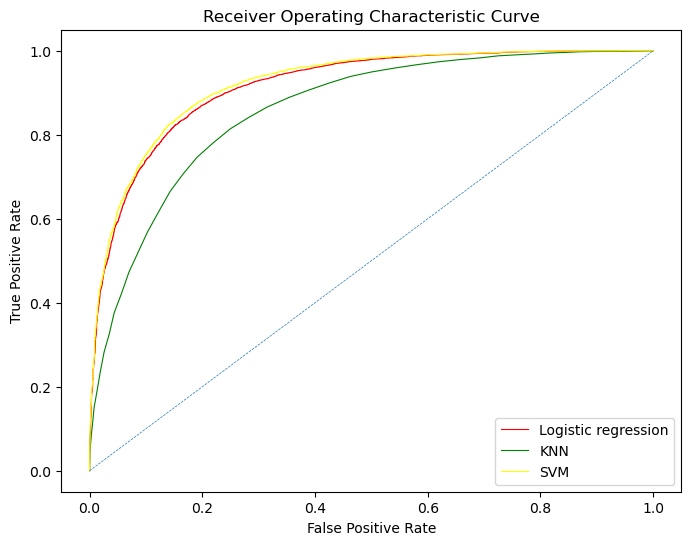

In [124]:
plt.figure(figsize=(8,6))
plt.title('Receiver Operating Characteristic Curve')
plt.plot(fpr_lr, tpr_lr, color='red', label='Logistic regression', linewidth=0.8)
plt.plot(fpr_knn, tpr_knn, color='green', label='KNN', linewidth=0.8)
plt.plot(fpr_svm, tpr_svm, color='yellow', label='SVM', linewidth=0.8)
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1], linestyle='--', linewidth=0.5)
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### Testiranje na novim podacima

In [137]:
new_reviews = ["This is super interesting and funny movie. Great casting", 
               "Red Notice was a great movie! Very entertaining, I also loved the dynamic between the characters, it works really well. I like the stakes and all that takes place, I was genuinely surprised by parts of the movie in a good way! I look forward to and 100% want to see a sequel made for this great story",
               "I'm not sure what these high profile, talented actors were offered to involve themselves in such a mediocre film. Every plot point and twist seems to exist just to inject some sort of excitement into an increasingly boring narrative. There's no craftsmanship, half-assed foreshadowing, everything is just beat after beat of nonsensical thieving hijinks compounded on uninspired action set pieces. Red Notice is everything wrong with frivolous high budget action films that have little to no interest in making something remotely intelligent.",
               "It's lazy, barrel-scraping cinema at its worst."
              ]         

In [138]:
new_reviews_vec = tf_idf_vectorizer.transform(new_reviews)
new_reviews_vec.shape

(4, 353)

In [139]:
y_prob = lr_model.predict_proba(new_reviews_vec)
print(y_prob)
print('-------------')
# dobro je predvideo
print(np.argmax(y_prob, axis=1))

[[1.69571173e-01 8.30428827e-01]
 [4.01783147e-03 9.95982169e-01]
 [9.03133044e-01 9.68669560e-02]
 [9.99970392e-01 2.96083333e-05]]
-------------
[1 1 0 0]


In [140]:
y_prob = svm_model.predict_proba(new_reviews_vec)
print(y_prob)
print('-------------')
# dobro je predvideo
print(np.argmax(y_prob, axis=1))

[[1.88906887e-01 8.11093113e-01]
 [7.60798871e-06 9.99992392e-01]
 [9.23151718e-01 7.68482823e-02]
 [9.99769150e-01 2.30850410e-04]]
-------------
[1 1 0 0]


In [141]:
y_prob = knn_model.predict_proba(new_reviews_vec)
print(y_prob)
print('-------------')
# dobro je predvideo (vidimo da je nesiguran za 1. i 3.)
print(np.argmax(y_prob, axis=1))

[[0.42 0.58]
 [0.06 0.94]
 [0.5  0.5 ]
 [1.   0.  ]]
-------------
[1 1 0 0]
